In [1]:
data_path = 'C:/work/model/WORLD/AICONFERENCE/NQ.csv'

In [2]:
# load dataset using read_csv()
from pandas import read_csv
series = read_csv(data_path, header=0, index_col=0, parse_dates=True, squeeze=True)
print(type(series))
print(series.head())


<class 'pandas.core.series.Series'>
timestamp
2005-06-29    2295.0
2005-06-30    2242.5
2005-07-01    2259.0
2005-07-02    2218.0
2005-07-03    2215.0
Name: NQ, dtype: float64


In [3]:
# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset
series = read_csv(data_path, header=0, index_col=0, parse_dates=True, squeeze=True)

# split dataset
X = series.values
train, test = X[1:len(X)-500], X[len(X)-500:]

# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
pyplot.plot(test, label='test')
pyplot.plot(predictions, color='red', label='predictions')
pyplot.legend()
pyplot.show()


Lag: 31
Coefficients: [ 0.4203773   0.98060816 -0.03630312  0.00266155  0.06609721 -0.04301578
 -0.00453875  0.04937191 -0.04230759 -0.00237258  0.02445691  0.054274
 -0.00379346  0.00184452 -0.08257245  0.01900181  0.06545908 -0.07008835
 -0.00971122  0.09293847 -0.07441147  0.03305159 -0.03619216  0.01328458
  0.00501242  0.03139301 -0.00885571  0.00780409 -0.03949042 -0.02950546
  0.02889476  0.00713688]
predicted=5438.053663, expected=5504.000000
predicted=5437.056136, expected=5548.250000
predicted=5439.479296, expected=5536.250000
predicted=5436.983774, expected=5591.000000
predicted=5429.622655, expected=5580.500000
predicted=5430.479560, expected=5630.750000
predicted=5435.666231, expected=5639.750000
predicted=5436.988456, expected=5613.250000
predicted=5442.156349, expected=5625.750000
predicted=5443.589651, expected=5648.250000
predicted=5448.526858, expected=5655.500000
predicted=5451.057184, expected=5676.250000
predicted=5446.633802, expected=5675.500000
predicted=5444.12

<Figure size 640x480 with 1 Axes>

predicted=7567.256141, expected=7578.000000
predicted=7589.840006, expected=7668.750000
predicted=7669.117649, expected=7649.000000
predicted=7643.636444, expected=7661.250000
predicted=7642.991437, expected=7638.750000
predicted=7637.481283, expected=7531.750000
predicted=7538.361137, expected=7457.500000
predicted=7469.585339, expected=7438.500000
predicted=7456.771459, expected=7460.250000
predicted=7469.801360, expected=7512.000000
predicted=7515.448949, expected=7485.750000
predicted=7499.139619, expected=7564.500000
predicted=7572.909899, expected=7544.750000
predicted=7547.859557, expected=7436.250000
predicted=7448.958653, expected=7495.250000
predicted=7512.636078, expected=7497.500000
predicted=7491.200197, expected=7579.750000
predicted=7573.779600, expected=7589.000000
predicted=7587.383405, expected=7586.000000
predicted=7585.661674, expected=7595.250000
predicted=7609.192440, expected=7590.250000
predicted=7595.010928, expected=7657.250000
predicted=7661.214723, expected=

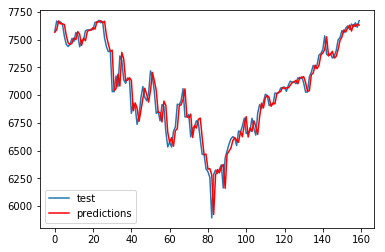

In [4]:
# create and evaluate an updated autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset
series = read_csv(data_path, header=0, index_col=0, parse_dates=True, squeeze=True)

# split dataset
X = series.values
train, test = X[1:len(X)-160], X[len(X)-160:]

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
pyplot.plot(test, label='test')
pyplot.plot(predictions, color='red', label='predictions')
pyplot.legend()
pyplot.show()


In [5]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(data_path, header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)

# summarize first few rows
print(series.head())

ValueError: time data '1902005-06-29' does not match format '%Y-%m'

In [ ]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset

series = read_csv(data_path, header=0, index_col=0)

# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# plot forecasts against actual outcomes
pyplot.plot(test, label='Test')
pyplot.plot(predictions, color='red', label='Prediction')
pyplot.legend()
pyplot.show()

In [ ]:
# autocorrelation plot
autocorrelation_plot(series)
pyplot.show()

In [13]:
# fit an ARIMA model and plot residual errors
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot


# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWa

                             ARIMA Model Results                              
Dep. Variable:                   D.NQ   No. Observations:                 5038
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -26640.069
Method:                       css-mle   S.D. of innovations             47.889
Date:                Mon, 15 Apr 2019   AIC                          53294.139
Time:                        18:39:58   BIC                          53339.812
Sample:                             1   HQIC                         53310.140
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0571      0.586      1.805      0.071      -0.091       2.205
ar.L1.D.NQ    -0.0364      0.014     -2.582      0.010      -0.064      -0.009
ar.L2.D.NQ    -0.0686      0.014     -4.868      0.0

In [14]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

NameError: name 'residuals' is not defined